In [1]:
import os
from pprint import pprint
import sys
import json

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import pickle

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

In [45]:
# Cheating performance
cheat_thr_df = pd.read_csv('cheating_thresholds.csv')
adapt_thr_df = pd.read_csv('adapted_thresholds.csv')
shuffle_thr_df = pd.read_csv('adapted_thresholds_shuffle.csv')

def get_cheat_thr(dataset_str, model_version, fold_id, subject_id):
    subject_id = str(subject_id)
    row = cheat_thr_df[
        (cheat_thr_df.dataset == dataset_str) 
        & (cheat_thr_df.model == model_version)
        & (cheat_thr_df.fold == fold_id)
        & (cheat_thr_df.subject == subject_id)
    ]
    this_cheat_thr = row.cheat_thr.values.item()
    return this_cheat_thr

def get_adapt_thr(dataset_str, model_version, fold_id, subject_id, minutes):
    # min minutes:
    # MASS1: 6
    # MASS2: 3
    # MODA: 3
    # INTA: 5
    min_minutes_by_dataset = {
        'MASS-SS2-E1SS': 6,
        'MASS-SS2-E2SS': 3,
        'MASS-MODA': 3,
        'INTA-UCH': 5,
    }
    min_minutes = min_minutes_by_dataset[dataset_str]
    if minutes < min_minutes:
        return -1
    
    # Now we can read
    subject_id = str(subject_id)
    row = adapt_thr_df[
        (adapt_thr_df.dataset == dataset_str) 
        & (adapt_thr_df.model == model_version)
        & (adapt_thr_df.fold == fold_id)
        & (adapt_thr_df.subject == subject_id)
        & (adapt_thr_df.minutes == minutes)
    ]
    this_adapt_thr = row.adapt_thr.values.item()
    return this_adapt_thr


def get_adapt_thr_shuffle(dataset_str, model_version, fold_id, subject_id, minutes):
    # min minutes:
    # MASS1: 6
    # MASS2: 3
    # MODA: 5
    # INTA: 5
    min_minutes_by_dataset = {
        'MASS-SS2-E1SS': 6,
        'MASS-SS2-E2SS': 3,
        'MASS-MODA': 5,
        'INTA-UCH': 5,
    }
    min_minutes = min_minutes_by_dataset[dataset_str]
    if minutes < min_minutes:
        return -1
    
    # Now we can read
    subject_id = str(subject_id)
    row = shuffle_thr_df[
        (shuffle_thr_df.dataset == dataset_str) 
        & (shuffle_thr_df.model == model_version)
        & (shuffle_thr_df.fold == fold_id)
        & (shuffle_thr_df.subject == subject_id)
        & (shuffle_thr_df.minutes == minutes)
    ]
    # print(row)
    this_adapt_thr = row.adapt_thr.values.item()
    return this_adapt_thr


def get_subject_ids(dataset):
    # In MODA, only some subjects are used (N=28)
    if dataset.dataset_name == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        # print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    return valid_subjects

In [46]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}
eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]

Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_mass_ss/v2_time
Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_mass_ss/v2_cwt1d
Loading checkpoint 20210529_thesis_indata_5cv_e2_n2_train_mass_ss/v2_time
Loading checkpoint 20210529_thesis_indata_5cv_e2_n2_train_mass_ss/v2_cwt1d
Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_moda_ss/v2_time
Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_moda_ss/v2_cwt1d
Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_inta_ss/v2_time
Loading checkpoint 20210529_thesis_indata_5cv_e1_n2_train_inta_ss/v2_cwt1d


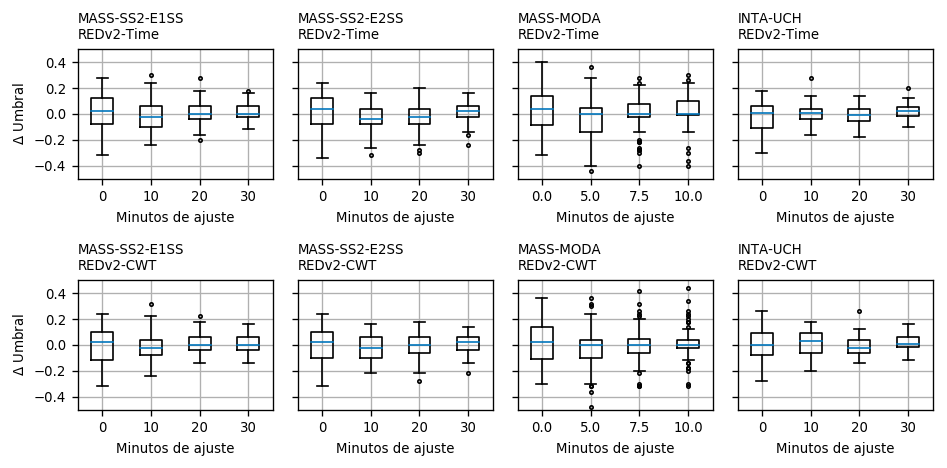

In [60]:

fig, axes = plt.subplots(2, 4, figsize=(8, 4), dpi=120, sharey=True)

minutes_list = [3, 5, 7.5, 10, 15, 20, 25, 30]

minutes_list = np.array(minutes_list)
for i_config, config in enumerate(eval_configs):
    
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    valid_subjects = get_subject_ids(dataset)
    ckpt_folder = '20210529_thesis_indata_%s_e%d_%s_train_%s' % (config["strategy"], config["expert"], constants.N2_RECORD, dataset.dataset_name)
    
    valid_minutes_list = minutes_list[minutes_list <= 10] if dataset_str == 'MASS-MODA' else [10, 20, 30]
    
    
    for i_model, model_version in enumerate(models):
        model_str = print_model_names[model_version]
        ax = axes[i_model, i_config]
        # #############
        minutes_extended = np.concatenate([[0], valid_minutes_list, [100]])
        thr_list_of_list = []

        
        grid_folder_complete = os.path.join(ckpt_folder, model_version)
        print("Loading checkpoint %s" % grid_folder_complete)
        for k in range(len(test_ids_list)):
            fold_subjects = test_ids_list[k]
            fold_thr = OPTIMAL_THR_FOR_CKPT_DICT[grid_folder_complete][k]
            for subject_id in fold_subjects:
                if subject_id not in valid_subjects:
                    continue
                subject_list = [fold_thr]
                for minutes in valid_minutes_list:
                    subject_adapt_thr = get_adapt_thr_shuffle(dataset_str, model_version, k, subject_id, minutes)
                    subject_list.append(subject_adapt_thr)
                subject_cheat_thr = get_cheat_thr(dataset_str, model_version, k, subject_id)
                subject_list.append(subject_cheat_thr)
                thr_list_of_list.append(subject_list)

        all_x_data = []
        all_y_data = []
        for data in thr_list_of_list:
            data = np.array(data)
            valid_locs = data >= 0
            x_data = minutes_extended[valid_locs]
            y_data = data[valid_locs]

            y_data = y_data - y_data[-1]
            y_data = y_data[:-1]
            x_data = x_data[:-1]

            all_x_data.append(x_data)
            all_y_data.append(y_data)
        all_x_data = all_x_data[0]
        all_y_data = list(np.stack(all_y_data, axis=0).T)
        
        ax.boxplot(all_y_data, labels=all_x_data, flierprops=dict(markersize=2), medianprops=dict(color=viz.PALETTE['blue']))
        
        if i_config == 0:
            ax.set_ylabel("$\Delta$ Umbral", fontsize=8)
        ax.set_xlabel("Minutos de ajuste", fontsize=8)
        ax.set_ylim([-0.5, 0.5])
        ax.tick_params(labelsize=8)
        ax.set_title('%s\n%s' % (dataset_str, model_str), fontsize=8, loc="left")
        ax.set_yticks(np.arange(-0.4, 0.4 + 0.001, 0.2))
        ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Graficar umbral a los 30 min vs cheat thr:

# config = eval_configs[1]
minutes_to_plot = 30
print_weird = False
top_weird = 10

fig, axes = plt.subplots(4, 4, figsize=(8, 10), dpi=120, sharex=True, sharey=True)

for i_config, config in enumerate(eval_configs):
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    valid_minutes_to_plot = min(minutes_to_plot, 10) if dataset_str == 'MASS-MODA' else minutes_to_plot
    
    
    for i_m, model_version in enumerate(models):

        cheat_thr_list = []
        fold_thr_list = []
        adapt_thr_list = []
        adapt_thr_shuffle_list = []
        subject_list = []
        for k in range(n_folds):
            fold_subjects = test_ids_list[k]
            valid_subjects = get_subject_ids(dataset)
            ckpt_folder = '20210529_thesis_indata_%s_e%d_%s_train_%s' % (
                config["strategy"], config["expert"], constants.N2_RECORD, dataset.dataset_name)
            grid_folder_complete = os.path.join(ckpt_folder, model_version)
            fold_thr = OPTIMAL_THR_FOR_CKPT_DICT[grid_folder_complete][k]
            for subject_id in fold_subjects:
                if subject_id not in valid_subjects:
                    continue
                
                subject_adapt_thr = get_adapt_thr(dataset_str, model_version, k, subject_id, valid_minutes_to_plot)   
                subject_adapt_thr_shuffle = get_adapt_thr_shuffle(dataset_str, model_version, k, subject_id, valid_minutes_to_plot)   
                subject_cheat_thr = get_cheat_thr(dataset_str, model_version, k, subject_id)
                
                adapt_thr_shuffle_list.append(subject_adapt_thr_shuffle)
                cheat_thr_list.append(subject_cheat_thr)
                fold_thr_list.append(fold_thr)
                adapt_thr_list.append(subject_adapt_thr)
                subject_list.append(subject_id)
        cheat_thr_list = np.array(cheat_thr_list)
        fold_thr_list = np.array(fold_thr_list)
        adapt_thr_list = np.array(adapt_thr_list)
        adapt_thr_shuffle_list = np.array(adapt_thr_shuffle_list)
        subject_list = np.array(subject_list)

        ax = axes[i_config, 0 + i_m * 2]
        ax.plot(cheat_thr_list, adapt_thr_list, linestyle="none", marker='o', markersize=5, alpha=0.3)
        ax.set_title('%s\n%s' % (dataset_str, model_version), fontsize=8)
        ax.set_xlabel("Cheat thr", fontsize=8)
        ax.set_ylabel("Adapt thr (%s min)" % valid_minutes_to_plot, fontsize=8)

        ax = axes[i_config, 1 + i_m * 2]
        ax.plot(cheat_thr_list, adapt_thr_shuffle_list, linestyle="none", marker='o', markersize=5, alpha=0.3)
        ax.set_title('%s\n%s' % (dataset_str, model_version), fontsize=8)
        ax.set_xlabel("Cheat thr", fontsize=8)
        ax.set_ylabel("Shuffle thr (%s min)" % valid_minutes_to_plot, fontsize=8)

        if print_weird:
            sorted_locs = np.argsort(-np.abs(cheat_thr_list - adapt_thr_list))
            for loc in sorted_locs[:top_weird]:
                print("Subject %s with cheat %1.2f and adapt %1.2f" % (subject_list[loc], cheat_thr_list[loc], adapt_thr_list[loc]))

for ax in axes.flatten():
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot([0, 1], [0, 1], linewidth=0.8, color="k")
    ax.grid()
    ax.set_aspect('equal')
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()